In [25]:
from google.colab import files

# Upload the images
uploaded = files.upload()

Saving image1.png to image1.png
Saving image2.png to image2.png
Saving image3.png to image3.png


<ipython-input-26-20f0ec21d323>:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve as filter2


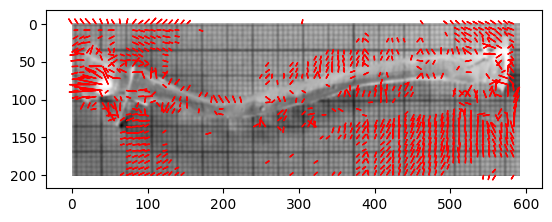

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import convolve as filter2
import os

def show_image(name, image):
    if image is None:
        return
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def crop_images(image1, image2):
    """ Crop images to the same size """
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])
    cropped_image1 = image1[:min_height, :min_width]
    cropped_image2 = image2[:min_height, :min_width]
    return cropped_image1, cropped_image2

def get_magnitude(u, v):
    scale = 3
    sum_magnitude = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            counter += 1
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum_magnitude += magnitude

    mag_avg = sum_magnitude / counter
    return mag_avg

def draw_quiver(u, v, beforeImg):
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap='gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            if magnitude > magnitudeAvg:
                ax.arrow(j, i, dx, dy, color='red')

    plt.draw()
    plt.show()

def get_derivatives(img1, img2):
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1, x_kernel) + filter2(img2, x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx, fy, ft]

def computeHS(img1_path, img2_path, alpha, delta):
    beforeImg = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise FileNotFoundError(f"Can't find image: \"{img1_path}\"")
    elif afterImg is None:
        raise FileNotFoundError(f"Can't find image: \"{img2_path}\"")

    beforeImg = beforeImg.astype(float)
    afterImg = afterImg.astype(float)

    beforeImg = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # Crop images if necessary
    beforeImg, afterImg = crop_images(beforeImg, afterImg)

    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        if diff < delta or iter_counter > 300:
            break

    draw_quiver(u, v, beforeImg)
    return u, v

if __name__ == '__main__':
    img1_path = 'image1.png'
    img2_path = 'image2.png'
    u, v = computeHS(img1_path, img2_path, alpha=15, delta=1e-1)


**1. Importing Libraries**

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import convolve as filter2
import os

<ipython-input-27-a66af26cecab>:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve as filter2


**2. Function Definitions**

Function to Display an Image

In [28]:
def show_image(name, image):
    """
    Display an image using OpenCV.
    """
    if image is None:
        return
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Function to Crop Images to the Same Size

In [29]:
def crop_images(image1, image2):
    """
    Crop two images to the same size based on the smallest dimensions.
    """
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])
    cropped_image1 = image1[:min_height, :min_width]
    cropped_image2 = image2[:min_height, :min_width]
    return cropped_image1, cropped_image2

Function to Calculate Magnitude of Optical Flow

In [30]:
def get_magnitude(u, v):
    """
    Calculate the magnitude of optical flow vectors and return the average magnitude.
    """
    scale = 3
    sum_magnitude = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            counter += 1
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum_magnitude += magnitude

    mag_avg = sum_magnitude / counter
    return mag_avg

Function to Draw Optical Flow Vectors

In [31]:
def draw_quiver(u, v, beforeImg):
    """
    Draw optical flow vectors on the image and display it.
    """
    scale = 6
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap='gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 50):
        for j in range(0, u.shape[1], 50):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            if magnitude > magnitudeAvg:
                 ax.arrow(j, i, dx, dy,
                         color='blue',  # Set color to blue
                         head_width=10,  # Increase head width
                         head_length=15,  # Increase head length
                         fc='blue',  # Fill color of the arrow head
                         ec='blue')  # Edge color of the arrow head
    plt.draw()
    plt.show()

Function to Compute Image Derivatives

In [32]:
def get_derivatives(img1, img2):
    """
    Compute image gradients in x, y directions and temporal gradient.
    """
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1, x_kernel) + filter2(img2, x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx, fy, ft]

Function to Compute Horn-Schunck Optical Flow

In [33]:
def computeHS(img1_path, img2_path, alpha, delta):
    """
    Compute the optical flow between two images using the Horn-Schunck method.
    """
    # Read images
    beforeImg = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise FileNotFoundError(f"Can't find image: \"{img1_path}\"")
    elif afterImg is None:
        raise FileNotFoundError(f"Can't find image: \"{img2_path}\"")

    beforeImg = beforeImg.astype(float)
    afterImg = afterImg.astype(float)

    # Apply Gaussian blur to reduce noise
    beforeImg = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # Crop images if necessary
    beforeImg, afterImg = crop_images(beforeImg, afterImg)

    # Initialize flow vectors
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)

    # Iteratively update flow vectors
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        if diff < delta or iter_counter > 300:
            break

    # Draw and show the optical flow vectors
    draw_quiver(u, v, beforeImg)
    return u, v

**3. Main Execution**

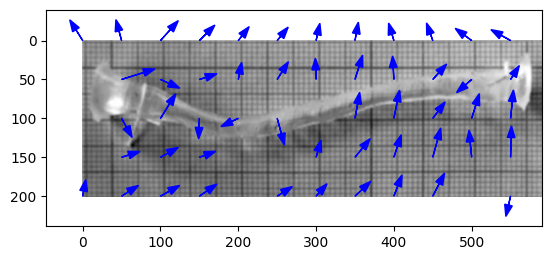

In [34]:
if __name__ == '__main__':
    # Set image file paths
    img1_path = 'image1.png'
    img2_path = 'image2.png'

    # Compute optical flow
    u, v = computeHS(img1_path, img2_path, alpha=15, delta=1e-1)